In [1]:
%matplotlib inline
from IPython.display import display, Math, Latex

import numpy as np
import matplotlib.pyplot as plt
import requests
from PIL import Image
from io import BytesIO

Text(0.5, 1.0, 'Input image')

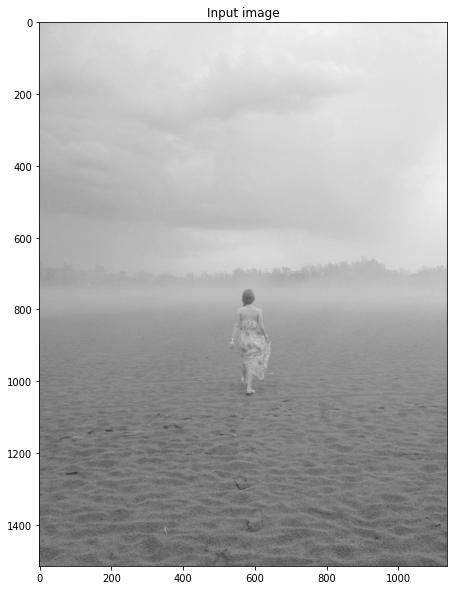

In [2]:
input_url = 'https://i.pinimg.com/originals/fa/95/87/fa9587af615f5670f430308f5ab42235.jpg'

response = requests.get(input_url)
input_img = Image.open(BytesIO(response.content)).convert('L')

#input_url = 'https://www.math.ust.hk/~masyleung/Teaching/CAS/MATLAB/image/images/lenna.jpg'

# display the image
figsize = (10,10)
plt.figure(figsize=figsize)

plt.imshow(input_img, cmap='gray', vmin=0, vmax=255)
plt.title("Input image")

Text(0.5, 1.0, 'Template image')

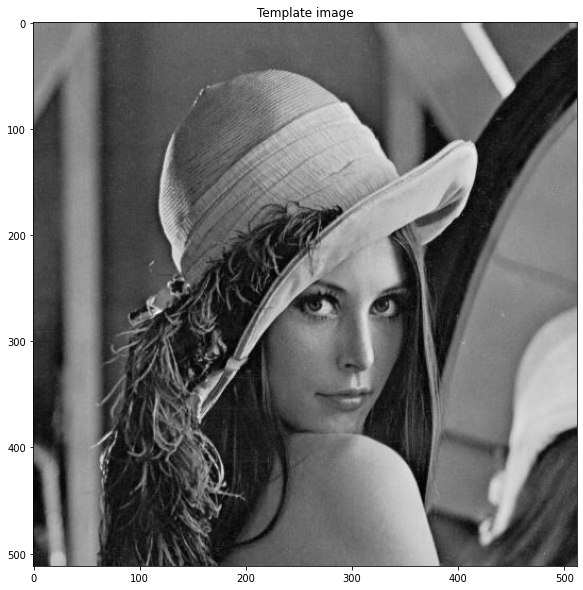

In [ ]:
template_url = 'https://www.math.ust.hk/~masyleung/Teaching/CAS/MATLAB/image/images/lenna.jpg'

response = requests.get(template_url)
template_img = Image.open(BytesIO(response.content)).convert('L')

# display the image
figsize = (10,10)
plt.figure(figsize=figsize)

plt.imshow(template_img, cmap='gray', vmin=0, vmax=255)
plt.title("Template image")

In [ ]:
def hist_match(source, template):
    """
    Adjust the pixel values of a grayscale image such that its histogram
    matches that of a target image

    Arguments:
    -----------
        source: np.ndarray
            Image to transform; the histogram is computed over the flattened
            array
        template: np.ndarray
            Template image; can have different dimensions to source
    Returns:
    -----------
        matched: np.ndarray
            The transformed output image
    """

    oldshape = source.shape
    source = source.ravel()
    template = template.ravel()

    # get the set of unique pixel values and their corresponding indices and
    # counts
    s_values, bin_idx, s_counts = np.unique(source, return_inverse=True,
                                            return_counts=True)
    t_values, t_counts = np.unique(template, return_counts=True)

    # take the cumsum of the counts and normalize by the number of pixels to
    # get the empirical cumulative distribution functions for the source and
    # template images (maps pixel value --> quantile)
    s_quantiles = np.cumsum(s_counts).astype(np.float64)
    s_quantiles /= s_quantiles[-1]
    t_quantiles = np.cumsum(t_counts).astype(np.float64)
    t_quantiles /= t_quantiles[-1]

    # interpolate linearly to find the pixel values in the template image
    # that correspond most closely to the quantiles in the source image
    interp_t_values = np.interp(s_quantiles, t_quantiles, t_values)

    return interp_t_values[bin_idx].reshape(oldshape)

In [ ]:
source = np.asarray(input_img)
template = np.asarray(template_img)

matched = hist_match(source, template)

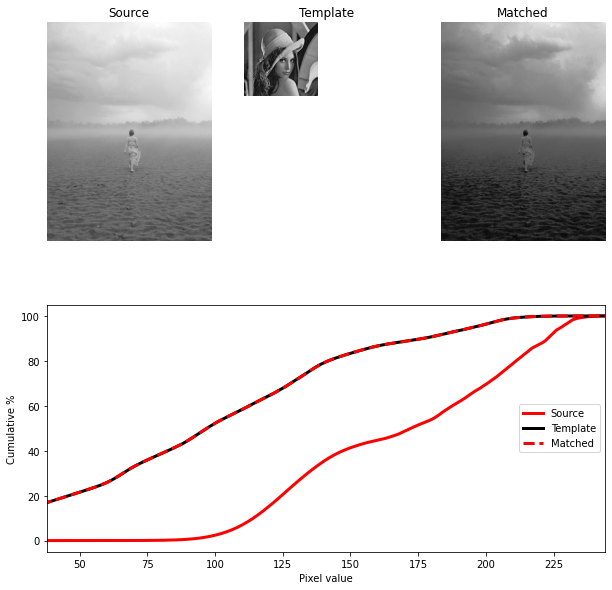

In [ ]:
def ecdf(x):
    """convenience function for computing the empirical CDF"""
    vals, counts = np.unique(x, return_counts=True)
    ecdf = np.cumsum(counts).astype(np.float64)
    ecdf /= ecdf[-1]
    return vals, ecdf

x1, y1 = ecdf(source.ravel())
x2, y2 = ecdf(template.ravel())
x3, y3 = ecdf(matched.ravel())

figsize = (10,10)
fig = plt.figure(figsize=figsize)

#plt.figure(figsize=figsize)
gs = plt.GridSpec(2, 3)
ax1 = fig.add_subplot(gs[0, 0])
ax2 = fig.add_subplot(gs[0, 1], sharex=ax1, sharey=ax1)
ax3 = fig.add_subplot(gs[0, 2], sharex=ax1, sharey=ax1)
ax4 = fig.add_subplot(gs[1, :])
for aa in (ax1, ax2, ax3):
    aa.set_axis_off()

ax1.imshow(source, cmap=plt.cm.gray)
ax1.set_title('Source')
ax2.imshow(template, cmap=plt.cm.gray)
ax2.set_title('Template')
ax3.imshow(matched, cmap=plt.cm.gray)
ax3.set_title('Matched')

ax4.plot(x1, y1 * 100, '-r', lw=3, label='Source')
ax4.plot(x2, y2 * 100, '-k', lw=3, label='Template')
ax4.plot(x3, y3 * 100, '--r', lw=3, label='Matched')
ax4.set_xlim(x1[0], x1[-1])
ax4.set_xlabel('Pixel value')
ax4.set_ylabel('Cumulative %')
ax4.legend(loc=5)